In [1]:
#numpy is for dealing with numpy arrays
import numpy as np

#pandas is for Data preprocessing 
import pandas as pd

#tensorflow used for various tasks in machine learning such as deep learning, neural networks, and natural language processing.
import tensorflow as tf

#Os to deal with OS functions
import os

#Keras is a high-level API for building and training neural networks, and it provides
#an intuitive and easy-to-use interface for developing machine learning models. 
from tensorflow import keras

#import statement that allows you to access the layers module
from tensorflow.keras import layers

#matplotlib.pyplot for visulization
import matplotlib.pyplot as plt

#Python import statement that allows you to access the Sequential class from the Keras API within TensorFlow.
from tensorflow.keras.models import Sequential

# **Preparing Dataset**

In [3]:
batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Projects\Plant Leaf classification project\dataset\image data\train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1837 files belonging to 9 classes.
Using 1470 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Projects\Plant Leaf classification project\dataset\image data\train',
  validation_split=0.3,
  subset="validation",
  seed=333,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1837 files belonging to 9 classes.
Using 551 files for validation.


In [5]:
class_names = train_ds.class_names

print(class_names)

['Cassava', 'apple', 'cherry (including sour)', 'grape', 'orange', 'pepper, bell', 'squash', 'strawberry', 'tomato']


In [6]:
# In the code block below, we are looping through the train_ds dataset and printing out the shapes of the image and label batches.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [7]:
# Autotune is a value that tells TensorFlow to automatically tune the buffer size based on available system resources.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9988195


In [10]:
# DATA Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

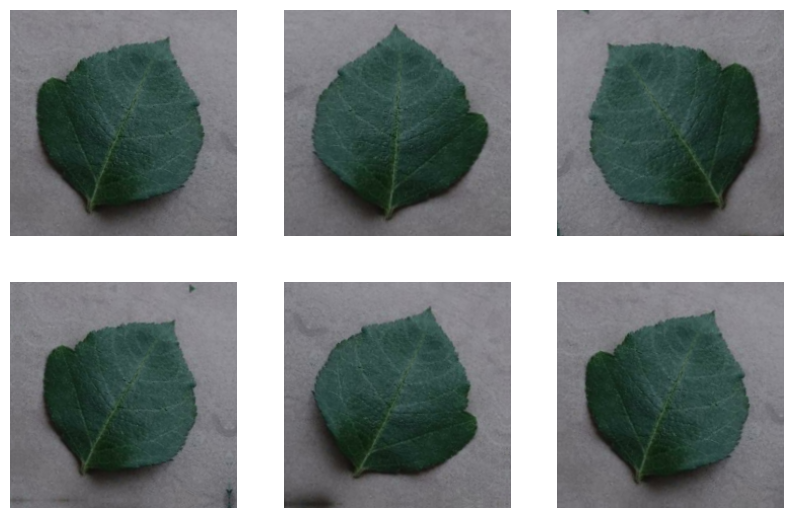

In [11]:
#Visualizing  six images from train_ds
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Training a CNN Model**

In [12]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
46/46 [==============================] - 33s 651ms/step - loss: 1.5912 - accuracy: 0.4728 - val_loss: 1.2784 - val_accuracy: 0.6007
Epoch 2/15
46/46 [==============================] - 31s 668ms/step - loss: 0.8509 - accuracy: 0.7150 - val_loss: 0.6628 - val_accuracy: 0.7659
Epoch 3/15
46/46 [==============================] - 29s 638ms/step - loss: 0.5326 - accuracy: 0.8156 - val_loss: 0.5865 - val_accuracy: 0.8348
Epoch 4/15
46/46 [==============================] - 29s 639ms/step - loss: 0.3806 - accuracy: 0.8701 - val_loss: 0.4610 - val_accuracy: 0.8693
Epoch 5/15
46/46 [==============================] - 29s 640ms/step - loss: 0.2773 - accuracy: 0.8986 - val_loss: 0.3531 - val_accuracy: 0.8911
Epoch 6/15
46/46 [==============================] - 28s 600ms/step - loss: 0.2340 - accuracy: 0.9272 - val_loss: 0.6438 - val_accuracy: 0.8421
Epoch 7/15
46/46 [==============================] - 27s 584ms/step - loss: 0.2775 - accuracy: 0.9061 - val_loss: 0.3700 - val_accuracy: 0.8657

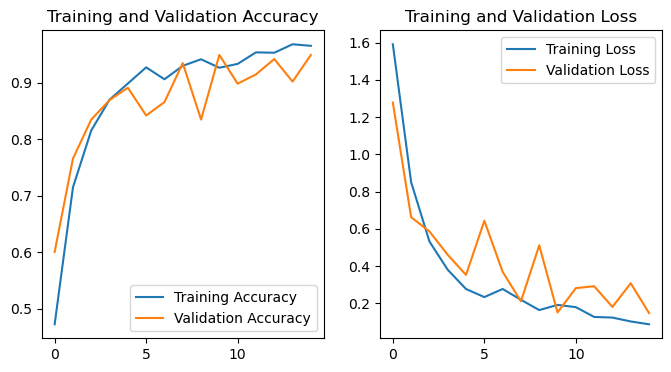

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Lets test our model on different picture

img = tf.keras.utils.load_img(
    r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Projects\Plant Leaf classification project\dataset\image data\test\apple\2b21526f-9ab0-444b-829a-fa97cd727733___RS_HL 7844.JPG', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to apple with a 99.24 percent confidence.
